In [3]:
import numpy as np
import numpy.random as npr
import math
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import time
import sys
import os

In [4]:
PATH = '../data/manual-SPAs/'
PATH_TO_VISUALS = '../../../thesis-visuals/'

# estimating ERA using SPAs

## collecting data

In [9]:
bmps = [2] + [i for i in range(20,201,20)]
items = 2
trials = 20_000_000
DPI = 150

In [57]:
# inverse cdf of 1 - 1/x
def ppf(y):
    return 1/(1-y)
ppf = np.vectorize(ppf)

revs_separate = []
revs_bundle = []

for bmp in bmps:
    revs_separate_temp = []
    revs_bundle_temp = []

    for i in tqdm(range(trials)):
        valuations = ppf(npr.random((bmp, items)))
        
        rev = np.sum(np.sort(valuations, 0)[-2,:])
        revs_separate_temp.append(rev)

        rev = np.sort(np.sum(valuations, 1), 0)[-2]
        revs_bundle_temp.append(rev)

    revs_separate.append(pd.Series(revs_separate_temp))
    revs_bundle.append(pd.Series(revs_bundle_temp))

[x.mean() - 2*n for x, n in zip(revs_bundle, bmps)]


rev_vals = np.array(bmps)
rev_cols = [f'rev_{x}' for x in rev_vals]

sep_df = pd.DataFrame(dict(zip(rev_cols, revs_separate)))
bun_df = pd.DataFrame(dict(zip(rev_cols, revs_bundle)))

sep_revs = sep_df.mean()
bun_revs = bun_df.mean()

sep_revs.name = 'rev_spa_separate'
bun_revs.name = 'rev_spa_bundle'

sep_conf = sep_df.apply(lambda a: st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))
bun_conf = bun_df.apply(lambda a: st.t.interval(0.95, len(a)-1, loc=np.mean(a), scale=st.sem(a)))

sep_conf = sep_conf.T
bun_conf = bun_conf.T
sep_conf.columns = ['0.95_conf_low_separate', '0.95_conf_high_separate']
bun_conf.columns = ['0.95_conf_low_bundle', '0.95_conf_high_bundle']

spa_data = pd.concat([sep_revs, bun_revs, sep_conf, bun_conf], axis=1).T

spa_data.to_csv(PATH + f'SPA_EQA_{trials}_trials.csv')

100%|██████████| 20000000/20000000 [53:10<00:00, 6268.28it/s] 


## graphing

In [6]:
spa_data = pd.read_csv(PATH + f'SPA_EQA_{trials}_trials.csv')
bun_revs = spa_data.iloc[1, 1:]
bun_conf = spa_data.iloc[4:, 1:]

In [7]:
from scipy.optimize import curve_fit

def log_func(x, a, b):
    return a * np.log(x) + b

def sqrt_func(x, a, b):
    return a * np.sqrt(x) + b

bmps = np.array(bmps)
x = bmps
y = bun_revs-2*bmps

popt_log, pcov_log = curve_fit(log_func, x, y)
popt_sqrt, pcov_sqrt = curve_fit(sqrt_func, x, y)

# Calculate the mean squared error of the fit
y_fit = log_func(x, *popt_log)
residuals = y - y_fit
mse_log = np.mean(residuals**2)

y_fit = sqrt_func(x, *popt_sqrt)
residuals = y - y_fit
mse_sqrt = np.mean(residuals**2)

# Print the parameters of the fitted function
print(popt_log, mse_log, popt_sqrt, mse_sqrt)

[0.98651884 0.13218504] 0.010176121430377662 [0.31757881 1.29384242] 0.15766822190007257


/var/folders/jf/z2mj2s1163z1wn19j7pvcdx40000gn/T/ipykernel_52277/2278493285.py:4: RuntimeWarning: divide by zero encountered in log
  return a * np.log(x) + b


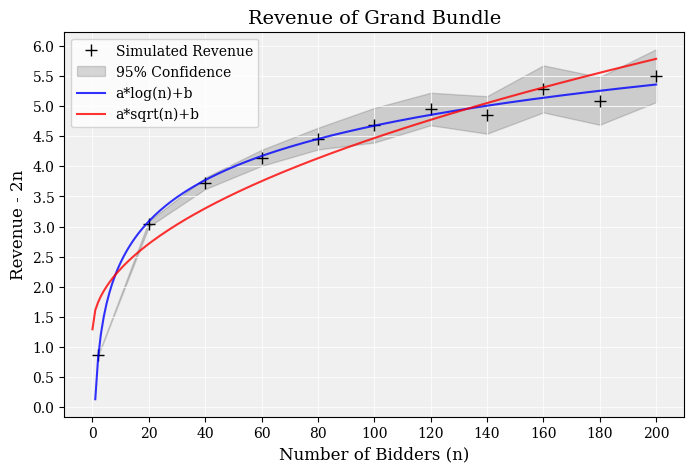

In [10]:
bmps = np.array(bmps)

plt.figure(figsize=(8,5))

plt.gca().set_facecolor('#f0f0f0')
plt.gca().grid(color='white', alpha=0.8)

temp = bun_conf - 2*bmps
# plt.plot(bmps, bun_revs - 2*bmps, ':', label='Revenue')
plt.rc('font', family='serif')

plt.plot(bmps, bun_revs - 2*bmps, '+', label='Simulated Revenue', markersize=8, color='black')
plt.fill_between(bmps, temp.T.iloc[:,0], temp.T.iloc[:,1], alpha=0.15, label='95% Confidence', color='black')


'''temp = sep_conf.T - 2*bmps
plt.fill_between(bmps, temp.T.iloc[:,0], temp.T.iloc[:,1], alpha=0.2)
plt.plot(bmps, sep_revs - 2*bmps, label='separate')'''

ticks = list(range(201))
#plt.plot(ticks, 1*np.log(ticks), label='log(n)')
plt.plot(ticks, [log_func(t, *popt_log) for t in ticks], 'b', label='a*log(n)+b', alpha=0.8)
plt.plot(ticks, [sqrt_func(t, *popt_sqrt) for t in ticks], 'r', label='a*sqrt(n)+b', alpha=0.8)

plt.xticks(range(0,201,20))
plt.yticks(np.array(range(0, 13, 1))/2)

plt.xlabel('Number of Bidders (n)', fontsize=12)
plt.ylabel('Revenue - 2n', fontsize=12)
plt.title('Revenue of Grand Bundle', fontsize=14)

plt.legend()
#plt.tight_layout()
# plt.savefig(PATH_TO_VISUALS+'re-era-bundle.png', dpi=DPI, bbox_inches='tight')
plt.show()